In [1]:
import re
import os

import pandas as pd
import nltk

Creating paths for files

In [2]:
dataDir = os.getcwd() + "\\data\\"
dataPost = dataDir + "Posts.csv"
dataReplies = dataDir + "Replies.csv"
dataScrape = dataDir + "webScrape.csv"

Separator for Posts is ^, Separator for Replies is `

In [3]:
comments = pd.read_csv(dataReplies, sep="`")

Checking data

In [4]:
comments.head()

,Reply,Upvote,Time,Key
0,The real question is wtf do the other mods eve...,16.0,2020-09-14 21:08:29,0.0
1,All hail W. \r\nPs: can we get ben back now?,7.0,2020-09-14 22:44:31,0.0
2,You should hire me for the soul purpose of del...,10.0,2020-09-14 21:30:23,0.0
3,"*Sees no ""No Hotshot allowed"" rule*\r\n\r\nhtt...",5.0,2020-09-14 20:58:34,0.0
4,I think it's a good thing that you see the nee...,1.0,2020-09-16 02:30:13,0.0


In [5]:
sample = comments.Reply.iloc[126]
sample

"Just to help you a bit... and give you a better answer [https://www.youtube.com/watch?v=ZQE22V76vLw&ab\\_channel=Sekapoko](https://www.youtube.com/watch?v=ZQE22V76vLw&ab_channel=Sekapoko) \r\n\r\nDepends on the character... If it's a DPS unit like derieri, or R.Esca or LV meli (characters like those, its better to go att/def with att/def/hp substats, otherwise just use Hp/def with att/def/hp substats to help you increase the cc team\r\n\r\nFor normal Pvp, every point matters (i.e. you have a 40k 6/6 ult association character, it will give 4000 cc points, 4 association characters in total means 16,000 cc), plus an additional 1000 cc if it has a combined attack (total of 20,000)\r\n\r\nSo yes, it does matters WHEN your main team is already maxed out... otherwise my recommendation is to keep maxing your team :)"

As stated in the tutorial, comments with URL will be unlikely to have an effect to the sentiments
Also we want to remove new line characters

In [6]:
comments.Reply = comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
comments.Reply = comments.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))
comments.Reply = comments.Reply.apply(lambda x: re.sub(r'[^0-9a-zA-Z]+',' ', x))
comments.Reply = comments.Reply.apply(lambda x: x.lower())

In [7]:
comments.head()

,Reply,Upvote,Time,Key
0,the real question is wtf do the other mods eve...,16.0,2020-09-14 21:08:29,0.0
1,all hail w ps can we get ben back now,7.0,2020-09-14 22:44:31,0.0
2,you should hire me for the soul purpose of del...,10.0,2020-09-14 21:30:23,0.0
3,sees no no hotshot allowed rule,5.0,2020-09-14 20:58:34,0.0
4,i think it s a good thing that you see the nee...,1.0,2020-09-16 02:30:13,0.0


In [8]:
from nltk.collocations import *
all_text = comments.iloc[:len(comments),:].Reply.str.cat(sep=". ")
all_text = nltk.word_tokenize(all_text)

Looking for common words in the comments

In [9]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq)
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))

[('sweet', 'temptation'), ('cruel', 'sun'), ('grand', 'cross'), ('fort', 'solgres'), ('lost', 'vayne'), ('training', 'cave'), ('ra', 'ra'), ('limit', 'break'), ('hawk', 'pass'), ('reverse', 'stages')]


In [10]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import random

all_text = comments.iloc[:len(comments),:].Reply.str.cat(sep=". ")

def grey_color_func(word, font_size, position, orientation, random_state = 10, **kwargs):
    return "hsl(0, 0%%,  %d%%)" % random.randint(1, 20)

Visualising using WordCloud

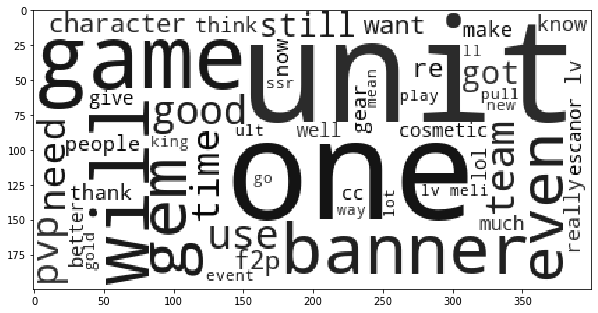

In [11]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color = "white", max_words = 50, stopwords = stp)
wc.generate(all_text)

plt.figure(figsize=(10, 20))
plt.imshow(wc.recolor(color_func = grey_color_func, random_state = 10))
plt.show()

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sid.polarity_scores("hell demon")

{'neg': 0.821, 'neu': 0.179, 'pos': 0.0, 'compound': -0.6808}

Removing the negative weight on the words hell demon as it is an in game boss

In [13]:
new_words = {
    "hell": 0,
    "demon": 0,
}
sid.lexicon.update(new_words)

Creating polarity scores for all the comments

In [14]:
comments[['neg', 'neu', 'pos', 'compound']] = comments.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [15]:
comments.head()

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,the real question is wtf do the other mods eve...,16.0,2020-09-14 21:08:29,0.0,0.132,0.868,0.000,-0.5859
1,all hail w ps can we get ben back now,7.0,2020-09-14 22:44:31,0.0,0.000,0.860,0.140,0.0772
2,you should hire me for the soul purpose of del...,10.0,2020-09-14 21:30:23,0.0,0.000,0.811,0.189,0.4215
3,sees no no hotshot allowed rule,5.0,2020-09-14 20:58:34,0.0,0.524,0.476,0.000,-0.5267
4,i think it s a good thing that you see the nee...,1.0,2020-09-16 02:30:13,0.0,0.000,0.724,0.276,0.8720


Removing the time value in the Time columns

In [16]:
def convertTime(time):
    return time[:10]
comments.Time = comments.Time.apply(lambda x: convertTime(x))
comments.head()

,Reply,Upvote,Time,Key,neg,neu,pos,compound
0,the real question is wtf do the other mods eve...,16.0,2020-09-14,0.0,0.132,0.868,0.000,-0.5859
1,all hail w ps can we get ben back now,7.0,2020-09-14,0.0,0.000,0.860,0.140,0.0772
2,you should hire me for the soul purpose of del...,10.0,2020-09-14,0.0,0.000,0.811,0.189,0.4215
3,sees no no hotshot allowed rule,5.0,2020-09-14,0.0,0.524,0.476,0.000,-0.5267
4,i think it s a good thing that you see the nee...,1.0,2020-09-16,0.0,0.000,0.724,0.276,0.8720


Creating the average value of compound in each day

In [17]:
final = comments.groupby(["Time"], as_index = False).agg({
    "compound":"mean"
})
final

,Time,compound
0,2020-09-08,0.075136
1,2020-09-09,0.137163
2,2020-09-10,0.172554
3,2020-09-11,0.173504
4,2020-09-12,0.198033
5,2020-09-13,0.207209
6,2020-09-14,0.196766
7,2020-09-15,0.239560
8,2020-09-16,0.193038
9,2020-09-17,0.161021


Plotting of Time against compound

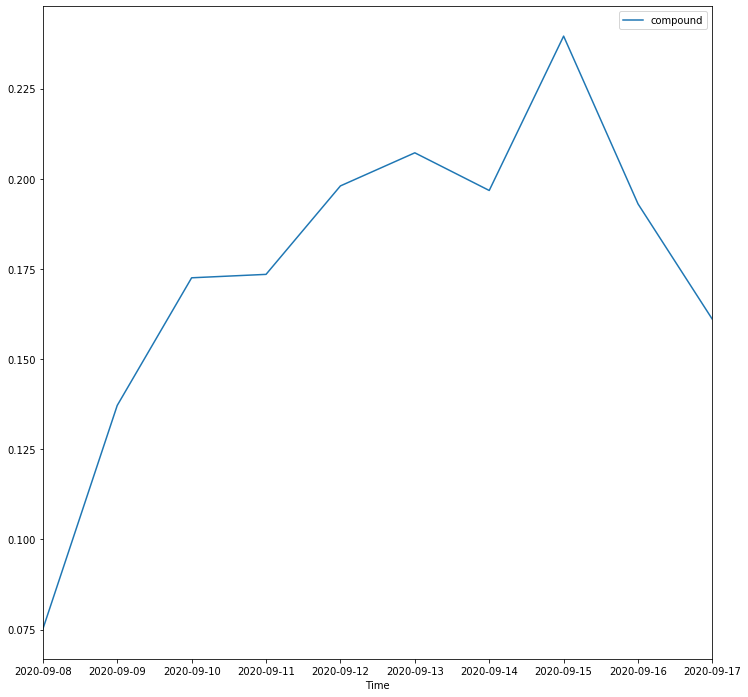

In [18]:
final.plot(x = "Time", y = "compound", kind = "line", figsize=(12,12))

Via webscraping, plotting the official forums % positive reaction rating against time

In [19]:
webScrape = pd.read_csv(dataScrape)
webScrape.head()

,Days,PercentPos
0,2020-09-17,0.571429
1,2020-09-15,0.615132
2,2020-09-14,0.644970
3,2020-09-12,0.894737
4,2020-09-11,0.378378


Reversing order of dataframe so that the it is in increasing dates

In [20]:
webScrape = webScrape.iloc[::-1]
webScrape.head()

,Days,PercentPos
6,2020-09-07,0.913043
5,2020-09-08,0.773438
4,2020-09-11,0.378378
3,2020-09-12,0.894737
2,2020-09-14,0.644970


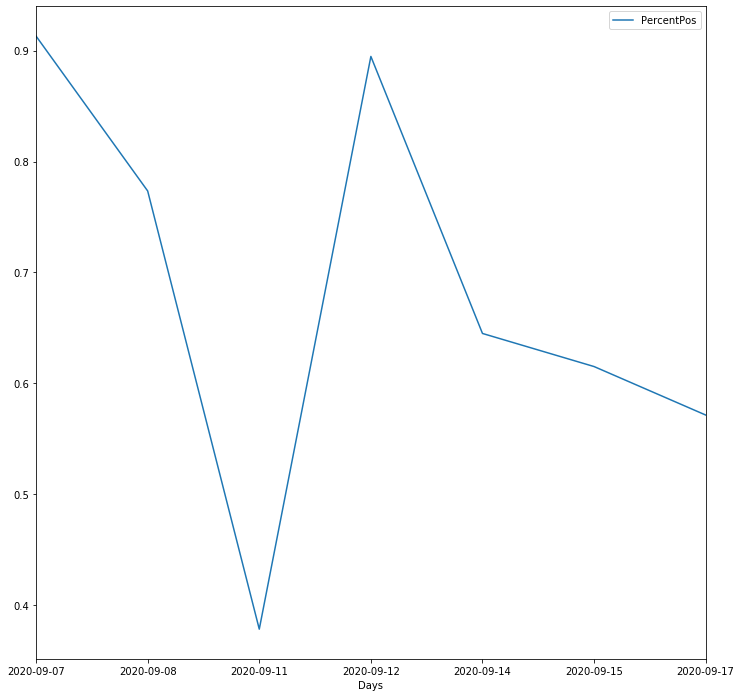

In [21]:
webScrape.plot(x = "Days", y = "PercentPos", kind = "line", figsize=(12,12))